# Modeling

### Setup & Data Loading

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sys
sys.path.append('../')

from src.preprocessing import preprocess_data, inverse_transform_target

# Loading and preprocessing Data
train = pd.read_csv('../data/train.csv')

train_processed, y_log, test_ids = preprocess_data(
    train, remove_outliers_flag=True
)

print(f"Training features: {train_processed.shape}")
print(f"Target (log): {y_log.shape}")

Start Preprocessing...
Deleted: 2 Outliers

1. Handeling Missing Values...
Missing Values handeled. Remaining NAs: 0

2. Encoding Ordinal Features...

Preprocessing Done!
Training Shape: (1458, 79)
Training features: (1458, 79)
Target (log): (1458,)


### One-Hot Encoding

In [46]:
# Identify categorical features (that are still of type object)
categorical_features = train_processed.select_dtypes(include=['object']).columns
print(f"Categorical Features: {len(categorical_features)}")
print(categorical_features.tolist())

# One-Hot Encoding
train_encoded = pd.get_dummies(train_processed, columns=categorical_features, drop_first=True)


print(f"\nAfter Encoding:")
print(f"Training: {train_encoded.shape}")

Categorical Features: 28
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']

After Encoding:
Training: (1458, 211)


C:\Users\Anwender\AppData\Local\Temp\ipykernel_16260\1525832765.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = train_processed.select_dtypes(include=['object']).columns


### Train/Validation Split

In [47]:
# Split for Model-Evaluation
X_train, X_val, y_train, y_val = train_test_split(
    train_encoded, y_log, test_size=0.2, random_state=42
)

print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")

Training Set: (1166, 211)
Validation Set: (292, 211)


#### Baseline Model - Linear Regression

In [48]:
# Simple Baseline-Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

# Metrics (on log-scale)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("=== Linear Regression ===")
print(f"Training RMSE (log): {train_rmse:.4f}")
print(f"Validation RMSE (log): {val_rmse:.4f}")
print(f"R² Score: {r2_score(y_val, y_val_pred):.4f}")

=== Linear Regression ===
Training RMSE (log): 0.0906
Validation RMSE (log): 0.2373
R² Score: 0.6659


### Ridge Regression (with regularization)

In [49]:
from sklearn.linear_model import RidgeCV

# Ridge mit Cross-Validation für Alpha
alphas = [0.1, 1, 10, 100, 1000]
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)

y_train_pred_ridge = ridge.predict(X_train)
y_val_pred_ridge = ridge.predict(X_val)

train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
val_rmse_ridge = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))

print("=== Ridge Regression ===")
print(f"Best Alpha: {ridge.alpha_}")
print(f"Training RMSE (log): {train_rmse_ridge:.4f}")
print(f"Validation RMSE (log): {val_rmse_ridge:.4f}")
print(f"R² Score: {r2_score(y_val, y_val_pred_ridge):.4f}")

=== Ridge Regression ===
Best Alpha: 10.0
Training RMSE (log): 0.1115
Validation RMSE (log): 0.1527
R² Score: 0.8617


### Random Forest

In [50]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_val_pred_rf = rf.predict(X_val)

train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))

print("=== Random Forest ===")
print(f"Training RMSE (log): {train_rmse_rf:.4f}")
print(f"Validation RMSE (log): {val_rmse_rf:.4f}")
print(f"R² Score: {r2_score(y_val, y_val_pred_rf):.4f}")

=== Random Forest ===
Training RMSE (log): 0.0632
Validation RMSE (log): 0.1575
R² Score: 0.8528


### Model Comparison

               Model  Validation RMSE
1   Ridge Regression         0.152696
2      Random Forest         0.157539
0  Linear Regression         0.237345


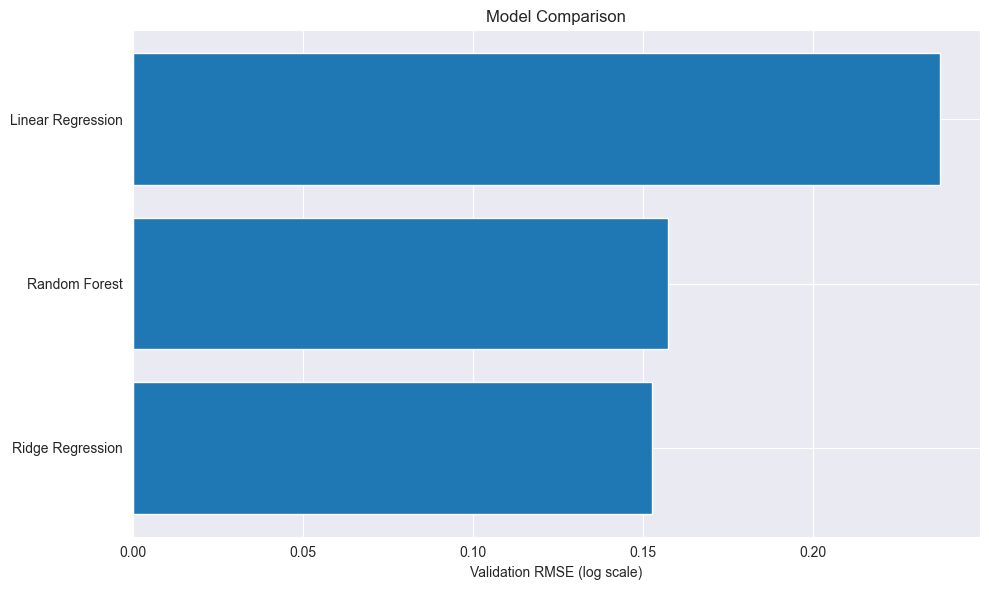

In [51]:
# Compare all Models.
models = {
    'Linear Regression': (lr, val_rmse),
    'Ridge Regression': (ridge, val_rmse_ridge),
    'Random Forest': (rf, val_rmse_rf)
}

results_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Validation RMSE': [val_rmse, val_rmse_ridge, val_rmse_rf]
}).sort_values('Validation RMSE')

print(results_df)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['Validation RMSE'])
plt.xlabel('Validation RMSE (log scale)')
plt.title('Model Comparison')
plt.tight_layout()
plt.show()